# <h1><b><I> General Setup

## Imports and general setup

In [1]:
import os, sys
sys.path.append("gammabayes/BFCalc/")
sys.path.append("gammabayes")

from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.utils.utils import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis, time,psf, edisp, bkgdist, interpolate, special, integrate
from gammabayes.utils.utils  import SkyCoord, WcsGeom, inverse_transform_sampling, tqdm#, setup_full_fake_signal_dist_copy_vers#, setup_full_fake_signal_dist, diff_irf_marg
from gammabayes.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.prior import discrete_logprior
from gammabayes.likelihood import discrete_loglikelihood
from gammabayes.utils.utils  import edisp_test, psf_test, log10eaxis, longitudeaxis, latitudeaxis
from gammabayes.utils.utils  import psf_efficient, edisp_efficient, edisp_test, psf_test, single_likelihood, read_config_file
from gammabayes.SS_DM_Prior import SS_DM_dist
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd


# For later in the notebook
from gammabayes.utils.utils import confidence_ellipse
from scipy.stats import norm

import time, pickle


/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
astrophysicalbackground = np.load("gammabayes/package_data/unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load("gammabayes/package_data/psfnormalisation.npy")
edispnormalisationvalues = np.load("gammabayes/package_data/edispnormalisation.npy")


In [3]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(901, 70, 60) (35, 30)


## Script Parameter Setup

In [4]:
inputs = read_config_file('example_run_script.yaml')

nsig = int(round(inputs['Nevents']*inputs['xi']))
nbkg = int(round(inputs['Nevents']*(1-inputs['xi'])))

startertimer = time.perf_counter()
print(startertimer)

file path: example_run_script.yaml
6119.823546542


# <h1><b>Simulation

## Setup

### Background setup

In [7]:
nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')


# unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))
unnormed_logbkgpriorvalues = np.squeeze(bkgdist(*nuisancemesh))

logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacobtrue)

logbkgpriorvalues.shape



# unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))
unnormed_logbkgpriorvalues = np.squeeze(bkgdist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [8]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [9]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(inputs["logmass"],), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x7fb8213b00d0>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

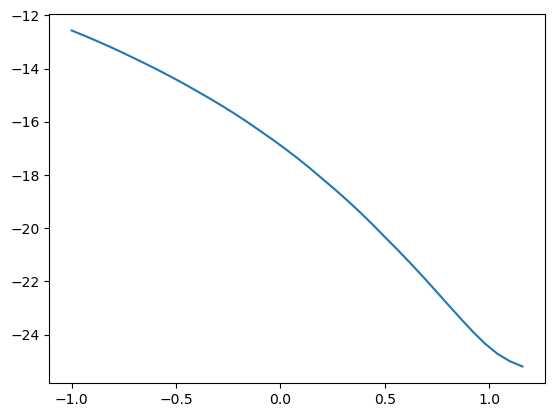

In [15]:
plotmesh = np.meshgrid(np.linspace(-1,2,51), 1.2, indexing='ij')

plt.plot(np.linspace(-1,2,51), 
         DM_prior.logfunction(plotmesh[0].flatten(), plotmesh[0].flatten()*0, plotmesh[0].flatten()*0, plotmesh[1].flatten()))

## True Value Simulation

In [8]:
if inputs['xi']!=0.0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

In [9]:

if inputs['xi']!=1.0:
    bkglogevals,bkglonvals,bkglatvals  = bkg_prior.sample(nbkg)
else:
    bkglogevals = np.asarray([])
    bkglonvals = np.asarray([])
    bkglatvals = np.asarray([])

## Reconstructed Value Simulation

In [10]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [11]:
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=edisp_test, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1
Number of dependent dimensions 1
Axes shape: (151,)


In [12]:
psf_like = discrete_loglikelihood(logfunction=psf_test, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2
Number of dependent dimensions 2


: 

### Signal

In [ ]:

if inputs['xi']!=0.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
else:
    signal_log10e_measured = np.asarray([])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 1563.81it/s]


In [ ]:

signal_lon_measured = []
signal_lat_measured = []

if inputs['xi']!=0:
    
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 172.71it/s]


### Background

In [ ]:
if inputs['xi']!=1.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    bkg_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
else:
    bkg_log10e_measured = np.asarray([])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1565.72it/s]


In [ ]:
bkg_lon_measured = []
bkg_lat_measured = []

if inputs['xi']!=1.0:
    
    bkg_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
    
    for bkg_lonlat_psf_sample in bkg_lonlat_psf_samples:
        bkg_lon_measured.append(bkg_lonlat_psf_sample[0])
        bkg_lat_measured.append(bkg_lonlat_psf_sample[1])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 171.92it/s]


## Final simulation output

In [ ]:


try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

# <h1><b>Analysis

## Marginalisation

In [ ]:


logmasswindowwidth      = 7/np.sqrt(nsig)

logmasslowerbound       = inputs['logmass']-logmasswindowwidth
logmassupperbound       = inputs['logmass']+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, inputs['nbins_logmass']) 

In [ ]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, bkg_prior,), likelihood=single_likelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), 
                                                               dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes_tuple = ((logmassrange,), (None,)), 
                                                               numcores=inputs['numcores'], 
                                                               likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.full_obs_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))

Setting up prior matrices: 100%|██████████████████| 2/2 [01:13<00:00, 36.59s/it]          


Starting nuisance parameter marginalisation
Sorry no progress bar for this step yet.


/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/utils/utils.py:145: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/utils/utils.py:149: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


Nuisance parameter marginalisation finished


In [ ]:
margresultsarray = np.asarray(hyperparameter_likelihood_instance.log_margresults).T
sigmargresults = np.vstack(margresultsarray[0,:]).T
bkgmargresults = np.vstack(margresultsarray[1,:])
sigmargresults.shape

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_5031/3449869552.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  margresultsarray = np.asarray(hyperparameter_likelihood_instance.log_margresults).T


(41, 1000)

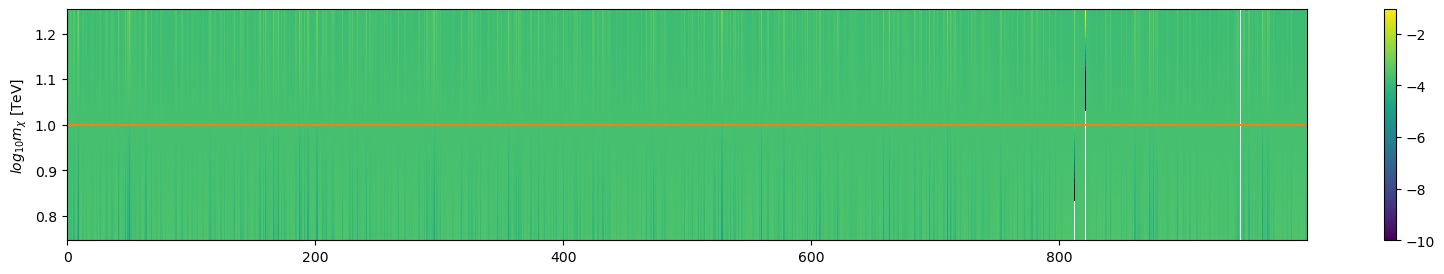

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(inputs['totalevents'])), logmassrange, indexing='ij'), 
               (sigmargresults-special.logsumexp(sigmargresults, axis=0)).T, 
               cmap='viridis', vmin=-10)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(inputs['logmass'], c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

In [ ]:

nbinslambda            = 81
lambdawindowwidth      = 9/np.sqrt(inputs['totalevents'])


lambdalowerbound       = inputs['xi']-lambdawindowwidth
lambdaupperbound       = inputs['xi']+lambdawindowwidth



if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, inputs['nbins_xi']) 

# log_posterior = []

# for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
#     log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

# log_posterior = np.array(log_posterior)-special.logsumexp(log_posterior)

hyperparameter_likelihood_instance.create_mixture_log_posterior(mixture_axes = (lambdarange, 1-lambdarange,))

log_posterior = np.squeeze(hyperparameter_likelihood_instance.unnormed_log_posterior)
endertimer = time.perf_counter()
print(endertimer-startertimer)

0 (101,) (1000, 41)
1 (101,) (1000, 1)
prioraxes:  [[0, 1, 2], [0, 1, 3]]
hyper_idx:  2
final_output_shape:  [(101,), 1000, 41, 1]
prior_idx:  0
axis: (3,)
mixture_array shape: (101, 1000, 41, 1)


prior_idx:  1
axis: (2,)
mixture_array shape: (101, 1000, 1, 1)


combined_mixture shape: (101, 1000, 41, 1)
final check: (101, 41, 1)
1806.785621708


# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_5031/2217560427.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.00505710325571113
0.0033714021704740853
0.0016857010852370444
0.0015324555320336748
0.0030649110640673495
0.004444121042897658


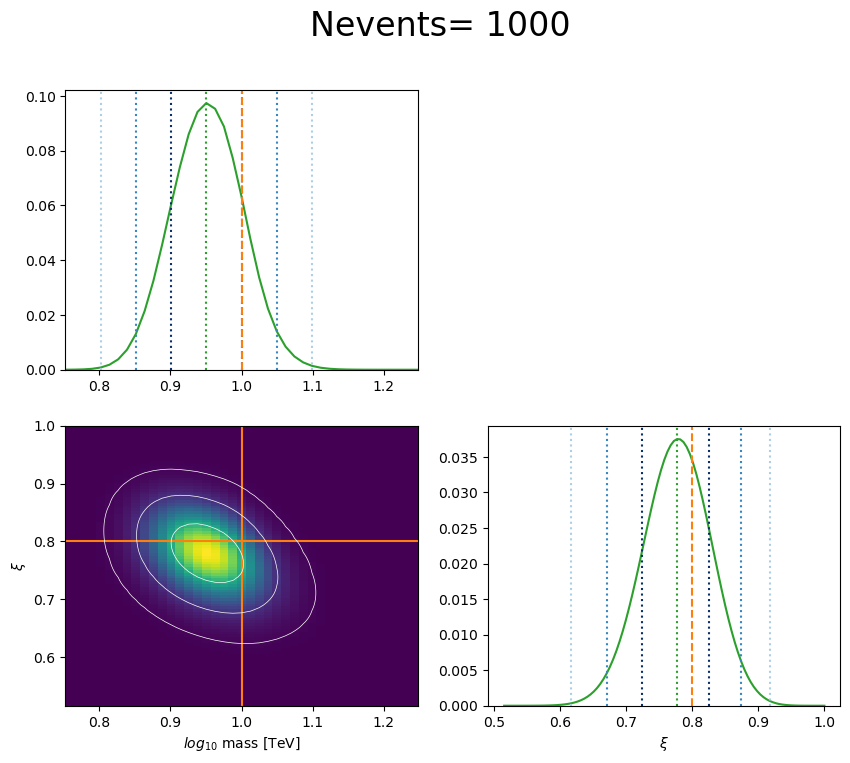

In [ ]:
log_posterior = log_posterior-special.logsumexp(log_posterior)

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {inputs['totalevents']}", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(inputs['logmass'], ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(inputs['logmass'], c='tab:orange')
ax[1,0].axhline(inputs['xi'], c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
try:
    normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
    n = 100000
    t = np.linspace(0, normed_posterior.max(), n)
    integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

    from scipy import interpolate
    f = interpolate.interp1d(integral, t)
    t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
    ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
except:
    warnings.warn("Couldn't create contour lines for posterior.")
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(lambdapercentile - meanlambda))





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(inputs['xi'], ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmass}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

In [ ]:
# hyperparameter_likelihood_instance.save_data()

In [ ]:
os.system('say Your code is finished.')


0

In [ ]:
import pickle

In [ ]:
testarray1 = np.array([-1, 2, 3, 4 , 5])
testarray2 = np.array([0.0, -1.25, -0.25, 0.4, 1.0])
testarray3 = np.array([0.0, 0.25, -0.3, -0.4, -0.7])


In [ ]:
[print(item) for item in zip(testarray1.tolist(), testarray2.tolist(), testarray3.tolist())]

(-1, 0.0, 0.0)
(2, -1.25, 0.25)
(3, -0.25, -0.3)
(4, 0.4, -0.4)
(5, 1.0, -0.7)


[None, None, None, None, None]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

X, Y = np.mgrid[-3:3:100j, -3:3:100j]

z1 = stats.multivariate_normal([0., 0.], [[.5, 0.], [0., .5]])
Z1 = z1.pdf(np.dstack((X, Y)))

z2 = stats.multivariate_normal([0.5, 0.5], [[.4, 0.], [0., .4]])
Z2 = z2.pdf(np.dstack((X, Y)))

z3 = stats.multivariate_normal([-1.5, 0.], [[.6, 0.], [0., .2]])
Z3 = z3.pdf(np.dstack((X, Y)))

z = Z1 + Z2 + Z3
z = z / z.sum()

n = 1000
t = np.linspace(0, z.max(), n)
integral = ((z >= t[:, None, None]) * z).sum(axis=(1,2))
integral = []
for t_val in t:
    result = (z >= t_val) 
    print(result)
    integral.append((result*z).sum())

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f([1.0 - np.exp(-0.5 * 2.0) ** 2, 1.0 - np.exp(-0.5 * 1.5) ** 2, 1.0 - np.exp(-0.5 * 1.0) ** 2,1.0 - np.exp(-0.5 * 0.5) ** 2])
plt.imshow(z.T, origin='lower', extent=[-3,3,-3,3], cmap="GnBu")
plt.contour(z.T, t_contours, extent=[-3,3,-3,3], cmap='Dark2')
plt.show()

SyntaxError: invalid syntax (3999739441.py, line 8)